In [2]:
from dotenv import load_dotenv
import os
import pandas as pd 
import numpy as np
import requests
import matplotlib.pyplot as plt

<h1>Запросы к API</h1>

Загрузка переменных окружения

In [5]:
load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

Данные API по посещениям за период с 2023-03-01 по 2023-09-01

In [7]:
visits_requests = requests.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})
visits = visits_requests.json()
visits_d = pd.DataFrame(visits)
visits_d.head() #Просмотр данных

,visit_id,platform,user_agent,datetime
0,1de9ea66-70d3-4a1f-8735-df5ef7697fb9,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01T10:36:22
1,f149f542-e935-4870-9734-6b4501eaf614,web,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...,2023-03-01T06:25:00
2,08f0ebd4-950c-4dd9-8e97-b5bdf073eed1,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,2023-03-01T10:26:13
3,19322fed-157c-49c6-b16e-2d5cabeb9592,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,2023-03-01T12:33:06
4,04762a22-3c9f-40c9-9ac9-6628c4381836,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01T01:38:35


In [8]:
visits_d.describe() #Предварительный анализ визитов

,visit_id,platform,user_agent,datetime
count,263459,263459,263459,263459
unique,146085,4,32,261204
top,64167edd-323a-4ab0-be9b-acd237a1ac30,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-07-06T10:45:50
freq,4,236301,13623,3


Данные API по регистрациям за период с 2023-03-01 по 2023-09-01

In [10]:
reg_requests = requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})
reg = reg_requests.json()
reg_d = pd.DataFrame(reg)
reg_d.head() #Просмотр данных

,datetime,user_id,email,platform,registration_type
0,2023-03-01T07:40:13,2e0f6bb8-b029-4f45-a786-2b53990d37f1,ebyrd@example.org,web,google
1,2023-03-01T13:14:00,f007f97c-9d8b-48b5-af08-119bb8f6d9b6,knightgerald@example.org,web,email
2,2023-03-01T03:05:50,24ff46ae-32b3-4a74-8f27-7cf0b8f32f15,cherylthompson@example.com,web,apple
3,2023-03-01T00:04:47,3e9914e1-5d73-4c23-b25d-b59a3aeb2b60,halldavid@example.org,web,email
4,2023-03-01T18:31:52,27f875fc-f8ce-4aeb-8722-0ecb283d0760,denise86@example.net,web,google


In [11]:
reg_d.describe() #Предварительный анализ регистраций

,datetime,user_id,email,platform,registration_type
count,21836,21836,21836,21836,21836
unique,21821,21836,20868,3,4
top,2023-06-23T13:10:45,2e0f6bb8-b029-4f45-a786-2b53990d37f1,ujones@example.com,android,email
freq,2,1,6,10582,8996


<h1>Расчет метрик</h1>

Расчитаем конверсию визитов в регистрации

Преобразуем в датафрейме визитов (visits_d) столбец **datetime** в формат даты в виде *'YYYY-MM-DD'*, оставим последний визит для каждого **visit_id**, исключим ботов и cгруппируем данные по датам и платформам.

In [15]:
visits_d['datetime'] = pd.to_datetime(visits_d['datetime']).dt.date
visits_data = visits_d.sort_values(['visit_id','datetime']).groupby('visit_id', as_index=False).last()
visits_data = visits_data[~visits_data['user_agent'].str.contains('bot')]

visit_group = visits_data.groupby(['datetime', 'platform'], as_index=False)['visit_id'].agg('count')
visit_group = visit_group.rename(columns={'visit_id': 'visits', 'datetime': 'date_group'})
visit_group.head() #Просмотр данных

,date_group,platform,visits
0,2023-03-01,android,75
1,2023-03-01,ios,22
2,2023-03-01,web,279
3,2023-03-02,android,67
4,2023-03-02,ios,31


Преобразуем в датафрейме регистраций (reg_data) столбец **datetime** в формат даты в виде *'YYYY-MM-DD'* и cгруппируем данные по датам и платформам.

In [17]:
reg_d['datetime'] = pd.to_datetime(reg_d['datetime']).dt.date
reg_data = reg_d.sort_values(['user_id','datetime'])

reg_group = reg_data.groupby(['datetime', 'platform'], as_index=False)['user_id'].agg('count')
reg_group = reg_group.rename(columns={'user_id': 'registrations', 'datetime': 'date_group'})
reg_group.head() #Просмотр данных

,date_group,platform,registrations
0,2023-03-01,android,61
1,2023-03-01,ios,18
2,2023-03-01,web,8
3,2023-03-02,android,59
4,2023-03-02,ios,24


Объединяем датайфреймы и подготавливаем итоговый датафрейм с расчетом конверсии

In [108]:
conversion = pd.merge(
    visit_group, reg_group, 
    left_on=['date_group', 'platform'], 
    right_on=['date_group', 'platform'], 
    how='outer')
conversion['conversion'] =  conversion['registrations'] / conversion['visits'] * 100
conversion = conversion.sort_values(['date_group'])
conversion.to_json('./conversion.json')
conversion.head() #Просмотр данных

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355


<h1>Информация по рекламе</h1>

Преобразуем в датафрейме с рекламными кампаниями (ads_data) столбец **date** в формат даты в виде *'YYYY-MM-DD'*.

In [22]:
ads_data = pd.read_csv('./ads.csv')
ads_data['date'] = pd.to_datetime(ads_data['date']).dt.date
ads_data = ads_data.rename(columns={'date': 'date_group'}) 
ads_data.head() #Просмотр данных

,date_group,utm_source,utm_medium,utm_campaign,cost
0,2023-03-01,google,cpc,advanced_algorithms_series,212
1,2023-03-02,google,cpc,advanced_algorithms_series,252
2,2023-03-03,google,cpc,advanced_algorithms_series,202
3,2023-03-04,google,cpc,advanced_algorithms_series,223
4,2023-03-05,google,cpc,advanced_algorithms_series,265


Сгруппируем датафрейм конверсии по столбцу **date_group**

In [24]:
conversion_date_group = conversion.groupby(['date_group'], as_index=False).agg('sum')
conversion_date_group = conversion_date_group[['date_group', 'visits', 'registrations']]
conversion_date_group.head()

,date_group,visits,registrations
0,2023-03-01,376,87
1,2023-03-02,613,106
2,2023-03-03,683,107
3,2023-03-04,647,159
4,2023-03-05,707,115


Объединим датафрейм с рекламными кампаниями с датайфреймом конверсий и сохраним данные в формате JSON

In [26]:
campaign_conversions = pd.merge(
    conversion_date_group, ads_data, 
    left_on=['date_group'], 
    right_on=['date_group'], 
    how='left')
campaign_conversions = campaign_conversions[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]
campaign_conversions = campaign_conversions.sort_values(['date_group'])

#Преобразование данных столбцов cost и utm_campaign
campaign_conversions['cost'] = campaign_conversions['cost'].fillna(0)
campaign_conversions['utm_campaign'] = campaign_conversions['utm_campaign'].fillna('none')

campaign_conversions.to_json('./ads.json')
campaign_conversions.head() #Просмотр данных

,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,376,87,212.0,advanced_algorithms_series
1,2023-03-02,613,106,252.0,advanced_algorithms_series
2,2023-03-03,683,107,202.0,advanced_algorithms_series
3,2023-03-04,647,159,223.0,advanced_algorithms_series
4,2023-03-05,707,115,265.0,advanced_algorithms_series


<h1>Визуализация данных</h1>

Создадим директорию ./charts для сохранения графиков в формате PNG 

In [29]:
os.makedirs('./charts', exist_ok=True)

<h3>Первый график - "Итоговые визиты"</h3>

In [31]:
#Подготовка данных для визуализации
visits_total = visit_group.groupby(['date_group'], as_index=False).agg('sum')

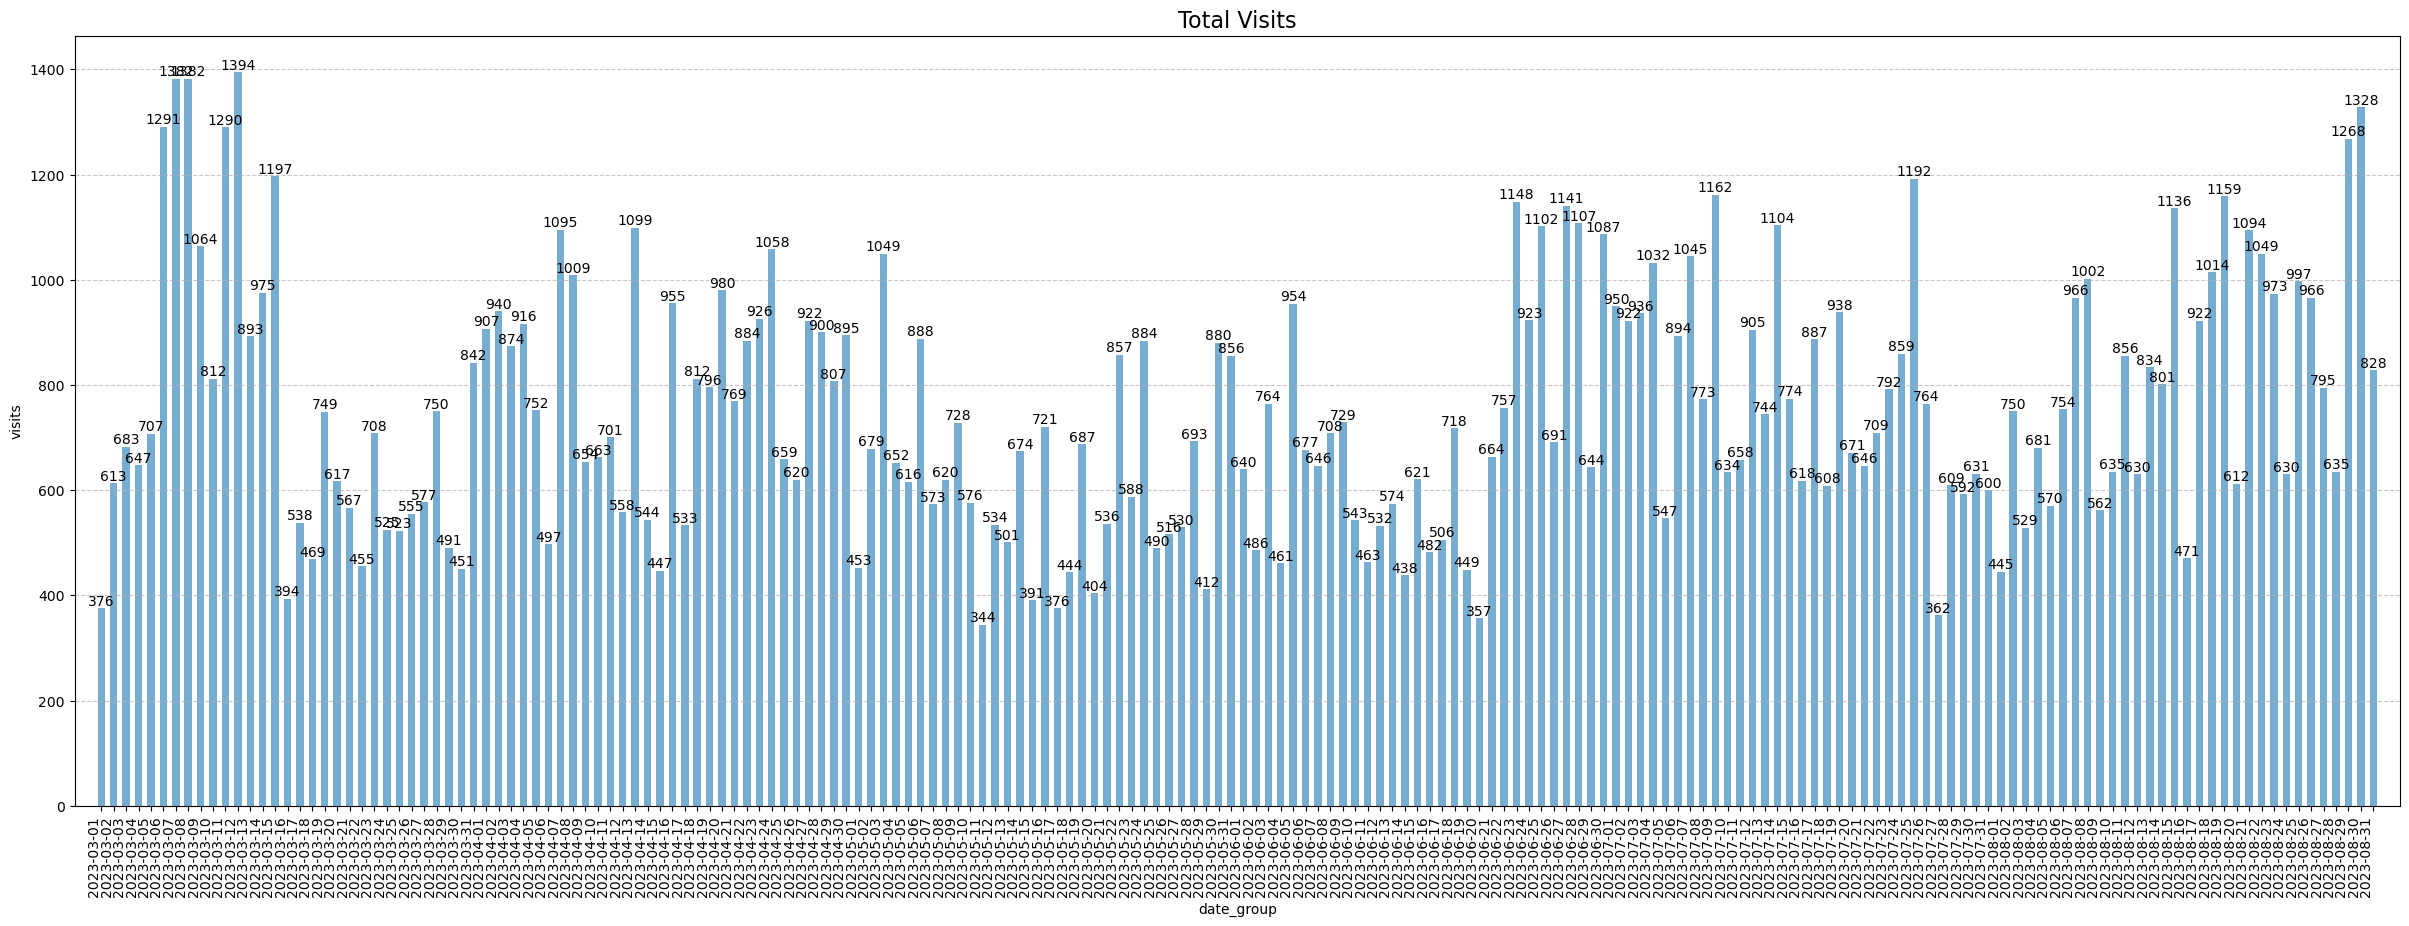

In [32]:
#Построение графика
plt.figure(figsize=(30,10))
plt.title('Total Visits', fontsize=16)
bars = plt.bar(visits_total['date_group'], visits_total['visits'], width=0.6, alpha=0.6)
plt.xlabel("date_group")
plt.ylabel("visits")
plt.xticks(visits_total['date_group'], rotation=90, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.margins(x=0.01)

for bar in bars:
    yval = bar.get_height()  
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=10)

plt.savefig('./charts/Total_visits.png')
plt.show()

**Вывод:** График показывает значительные колебания числа визитов по дням. Можно выделить периоды с повышенной (количество визитов достигает 1394) и пониженной активностью (количество визитов опускается ниже 400). Вероятно, такие колебания могут быть связаны с днями недели или с рекламными кампаниями, которые привлекают больше пользователей.

<h3>Второй график - "Итоговые визиты с разбивкой по платформам"</h3>

In [35]:
#Подготовка данных для визуализации
pivot_visits = visit_group.pivot(index='date_group', columns='platform', values='visits')

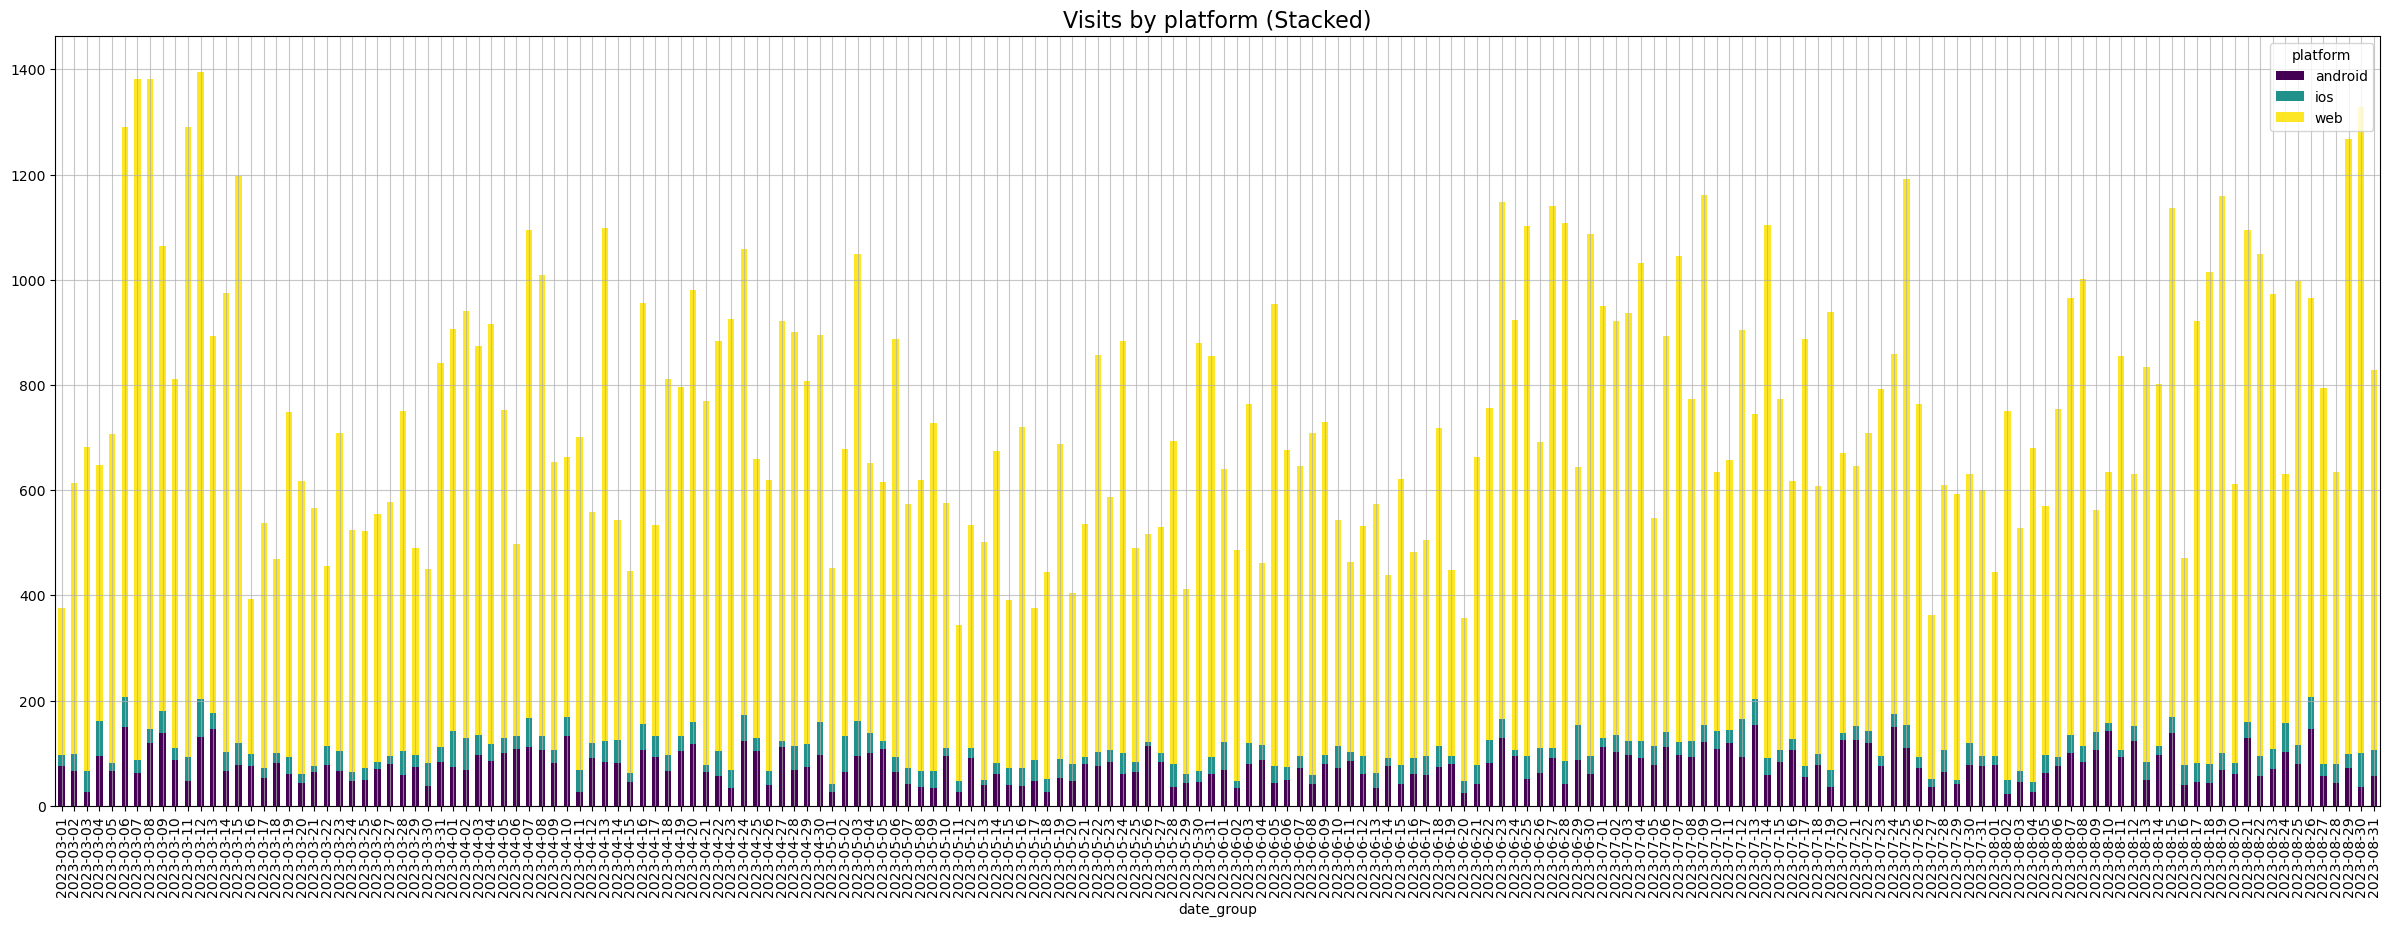

In [36]:
#Построение графика
pivot_visits.plot(kind='bar', stacked=True, figsize=(30, 10), colormap='viridis')

plt.title('Visits by platform (Stacked)', fontsize=16)
plt.xlabel("date_group")
plt.xticks(rotation=90)
plt.legend(title="platform", loc='upper right')
plt.grid(alpha=0.7)

plt.savefig('./charts/Visits_by_platform_(Stacked).png')
plt.show()

**Вывод:** График в разрезе по платформам показывает, что наибольшее число посещений осуществляется через платформу *web*. Визиты с *web* остаются доминирующими на протяжении всего периода, что может указывать на удобство использования сайта или большую аудиторию по сравнению с мобильными приложениями. *Android*  и *iOS*  имеют значительно меньшие значения по сравнению с *web*. Разница между *Android* и *iOS* незначительная, но *Android* немного опережает.

<h3>Третий график - "Итоговые регистрации"</h3>

In [39]:
#Подготовка данных для визуализации
reg_total = reg_group.groupby(['date_group'], as_index=False).agg('sum')

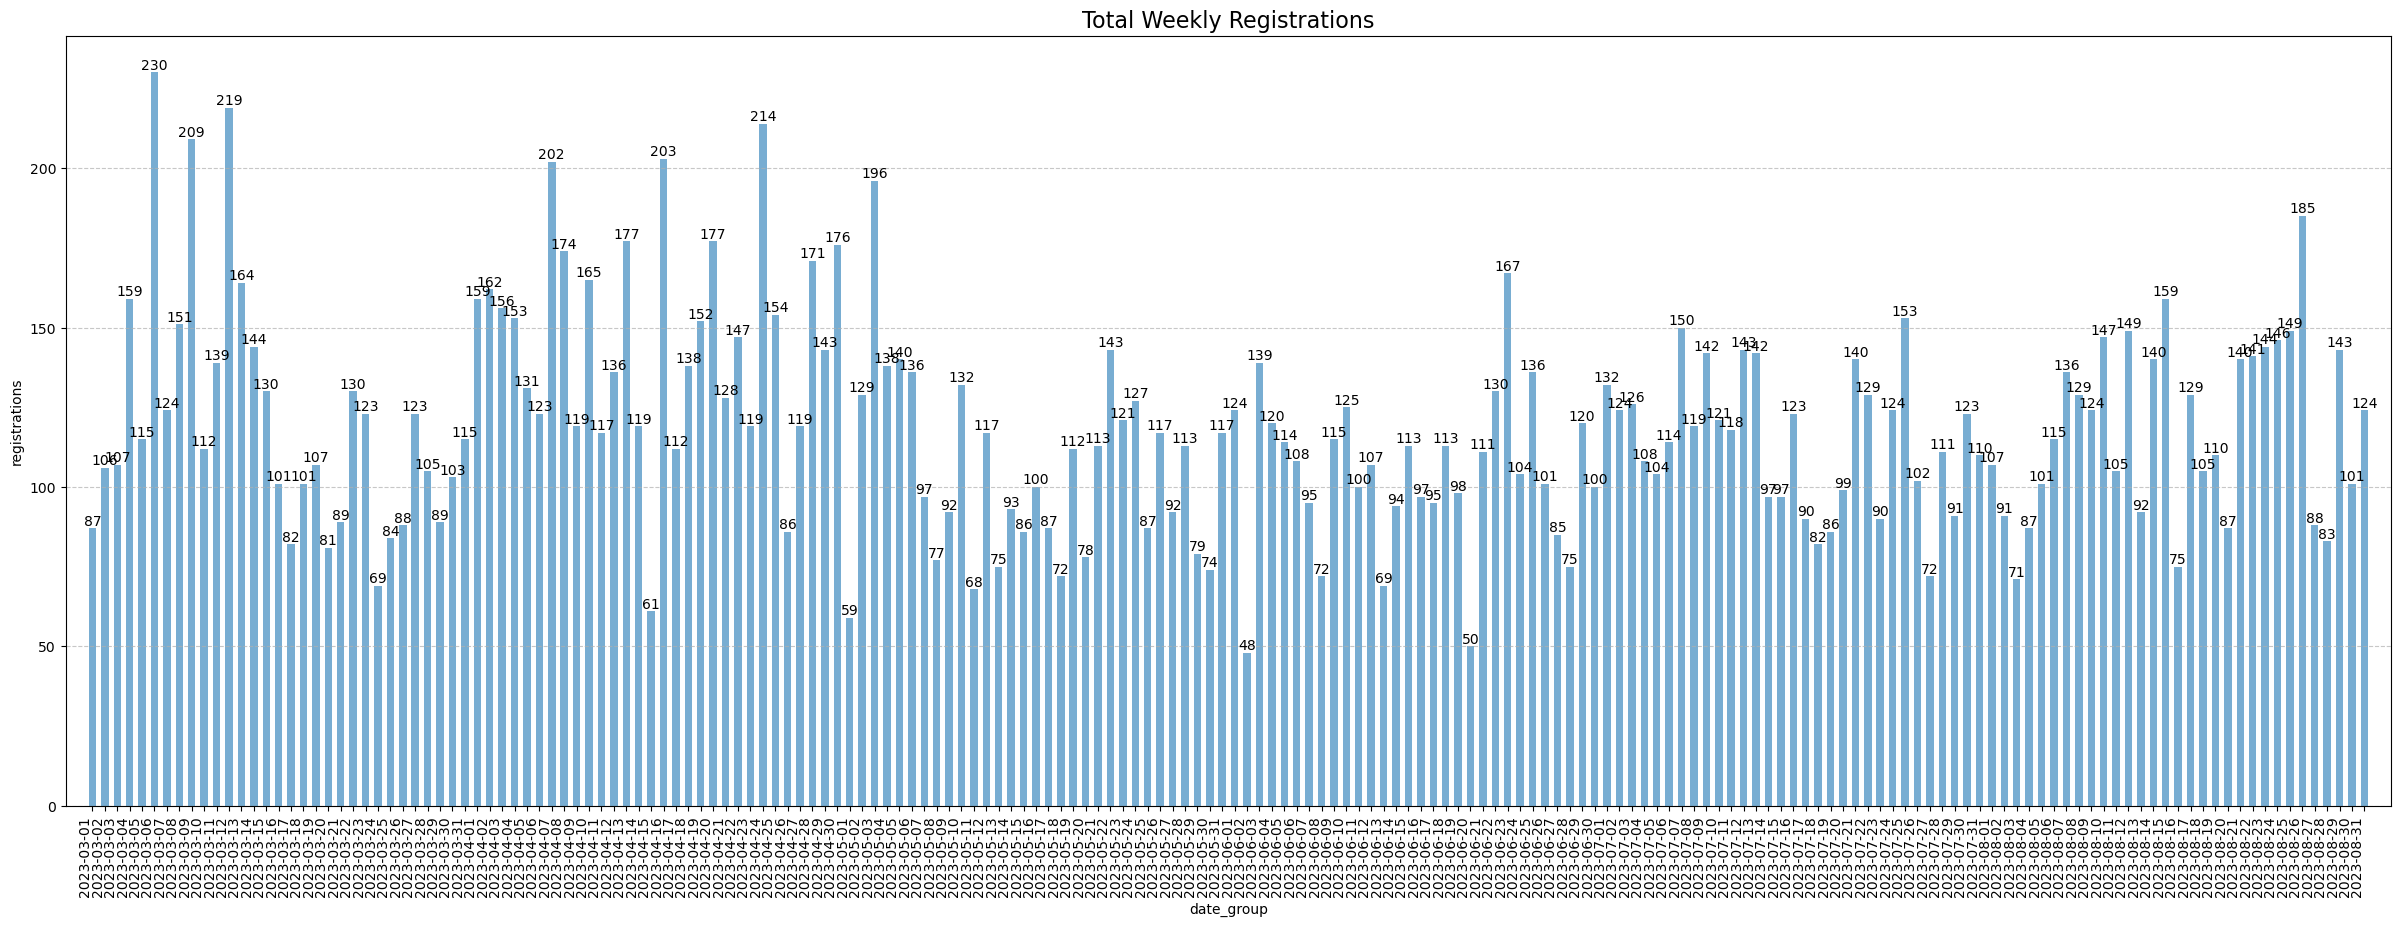

In [40]:
#Построение графика
plt.figure(figsize=(30,10))
plt.title('Total Weekly Registrations', fontsize=16)
bars = plt.bar(reg_total['date_group'], reg_total['registrations'], width=0.6, alpha=0.6)
plt.xlabel("date_group")
plt.ylabel("registrations")
plt.xticks(reg_total['date_group'], rotation=90, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.margins(x=0.01)

for bar in bars:
    yval = bar.get_height()  
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=10)

plt.savefig('./charts/Total_Weekly_Registrations.png')
plt.show()

**Вывод:** В целом, динамика регистраций нестабильна, есть выраженные пики (количество регистраций достигает 230) и спады (количество регистраций опускается ниже 60). В среднем, количество регистраций держится в диапазоне от 80 до 150. Рост числа регистраций может быть связан с рекламными кампаниями, а падения могут происходить из-за снижения интереса и отсутствия маркетинговой активности.

<h3>Четвертый график - "Итоговые регистрации с разбивкой по платформе"</h3>

In [43]:
#Подготовка данных для визуализации
pivot_reg = reg_group.pivot(index='date_group', columns='platform', values='registrations')

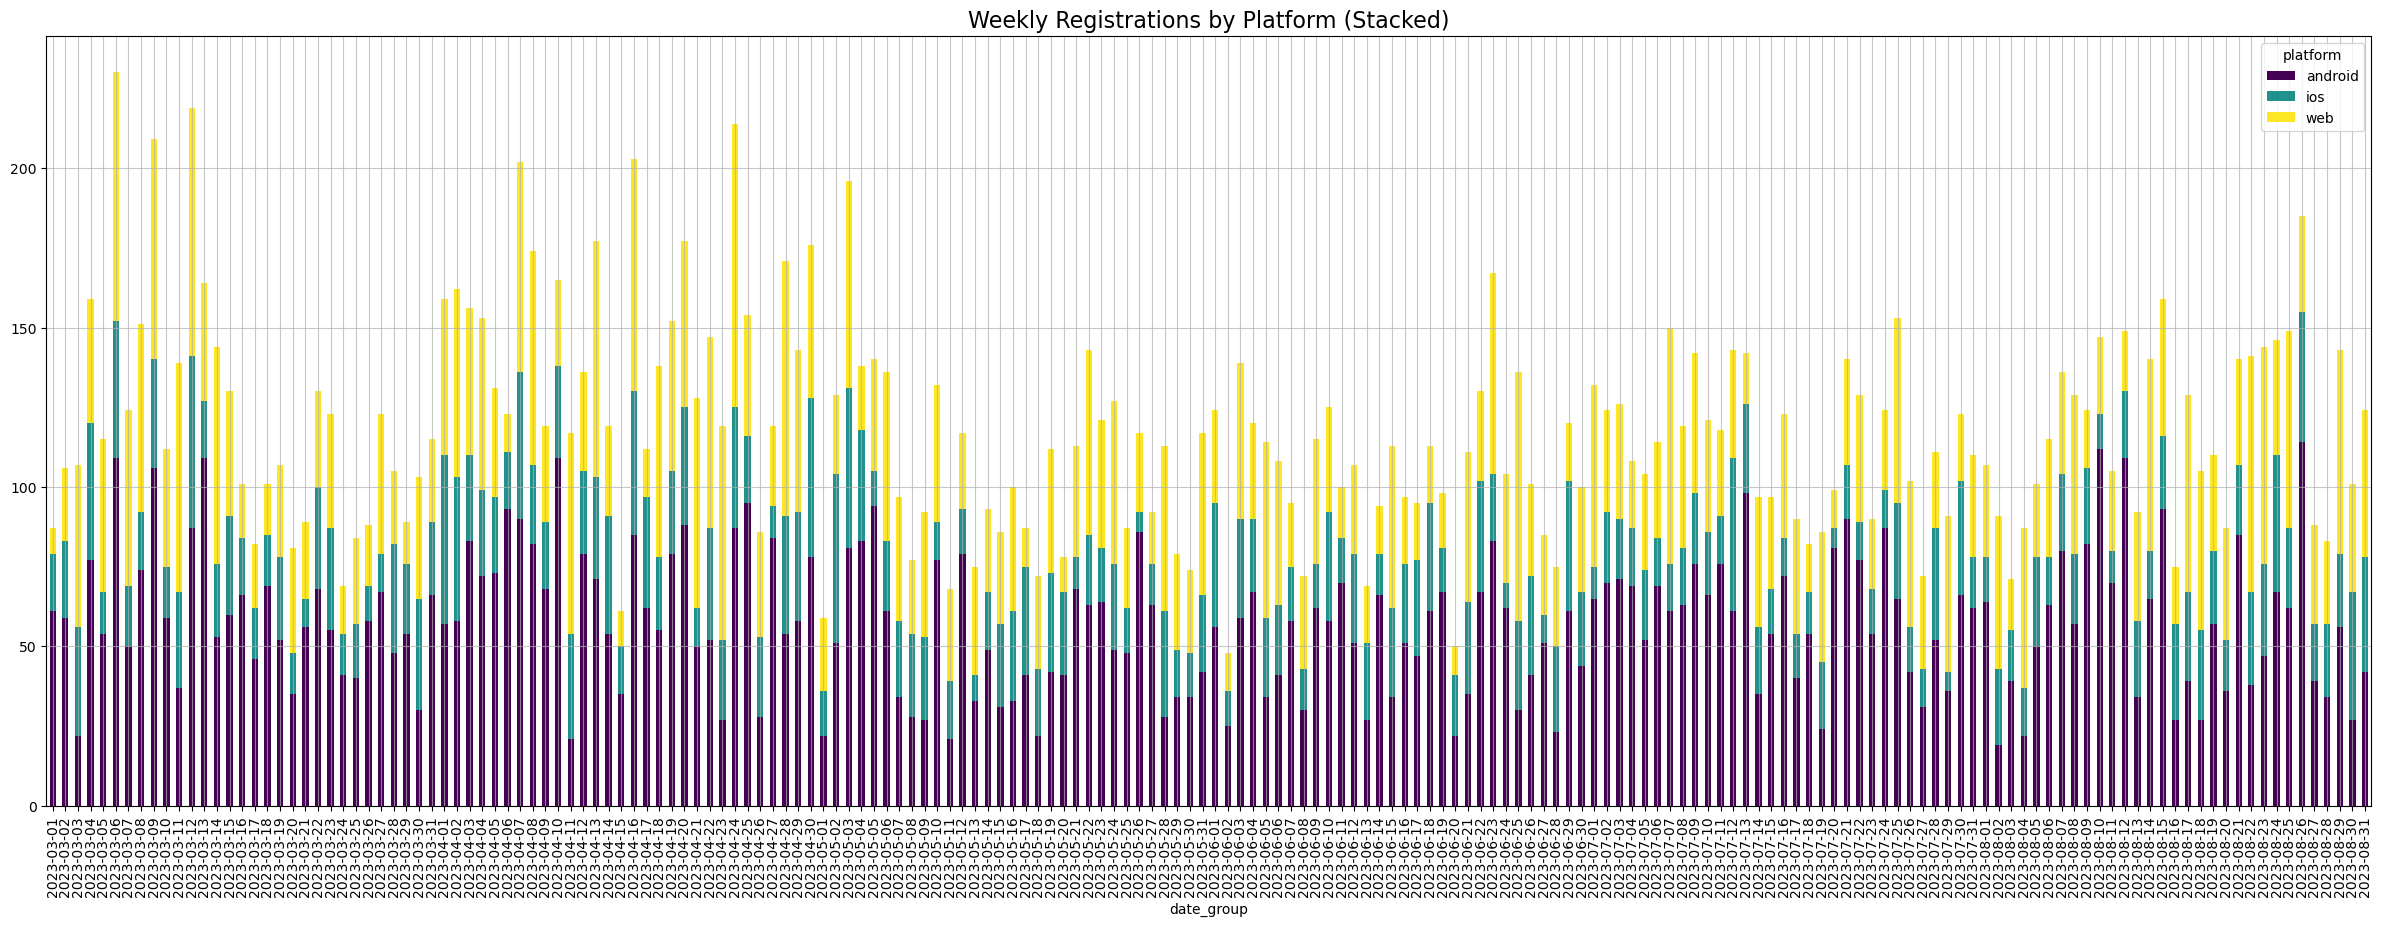

In [44]:
#Построение графика
pivot_reg.plot(kind='bar', stacked=True, figsize=(30, 10), colormap='viridis')

plt.title('Weekly Registrations by Platform (Stacked)', fontsize=16)
plt.xlabel("date_group")
plt.xticks(rotation=90)
plt.legend(title="platform", loc='upper right')
plt.grid(alpha=0.7)

plt.savefig('./charts/Weekly_Registrations_by_Platform_(Stacked).png')
plt.show()

**Вывод:** *Android* обеспечивает стабильность регистраций. *Web* платформа создает самые большие колебания, возможно, из-за рекламных акций или сезонности. *iOS* занимает промежуточное положение, но не оказывает значительного влияния на общую динамику.
Необходимо анализировать причины всплесков *Web* регистраций.

<h3>Пятый график - "Итоговые конверсии"</h3>

In [47]:
#Подготовка данных для визуализации
total_conversion = conversion.drop('conversion', axis=1)
total_conversion = total_conversion.groupby(['date_group'], as_index=False).agg('sum')
total_conversion['conversion'] =  total_conversion['registrations'] / total_conversion['visits'] * 100

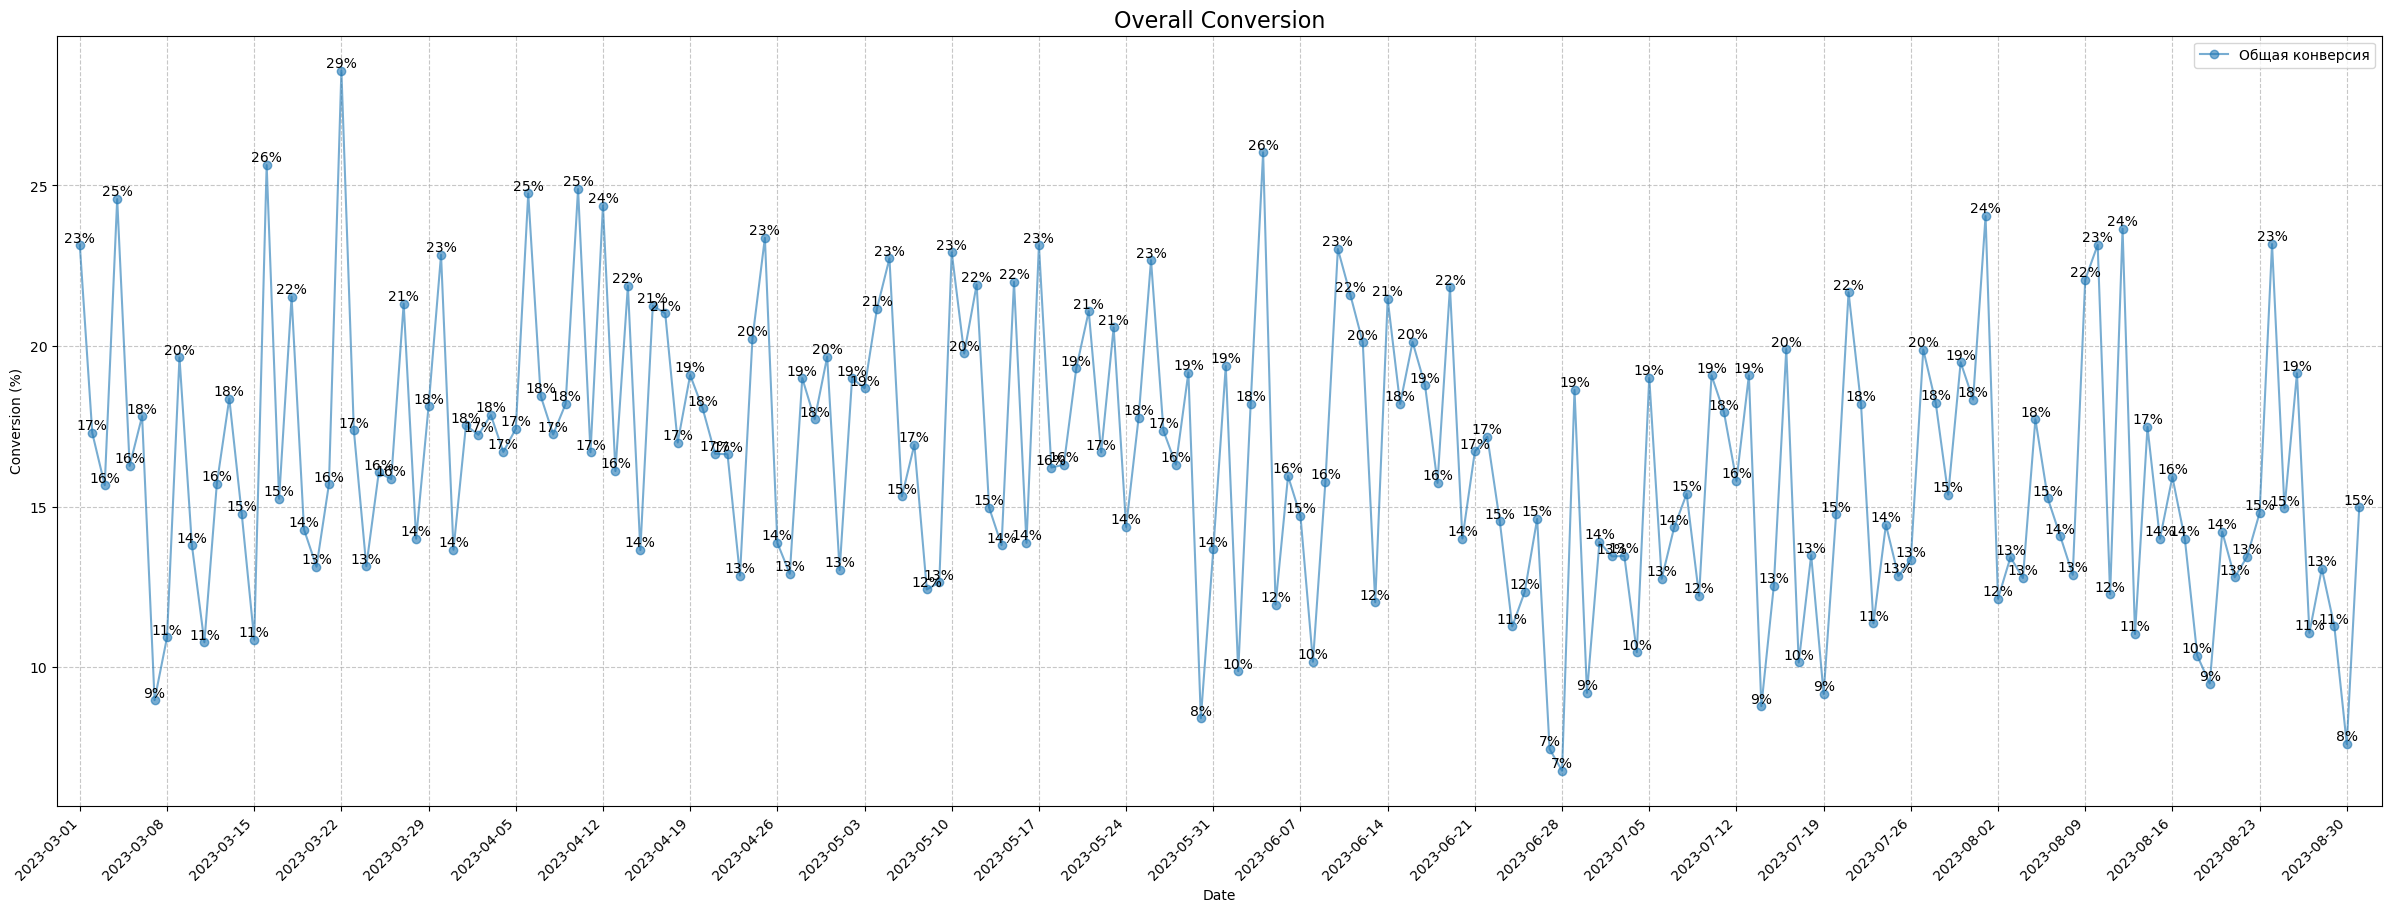

In [48]:
#Построение графика
plt.figure(figsize=(30,10))
plt.title('Overall Conversion', fontsize=16)
plt.plot(total_conversion['date_group'], total_conversion['conversion'], marker='o', label="Общая конверсия", alpha=0.6)
plt.xlabel("Date")
plt.ylabel("Conversion (%)")
plt.xticks(total_conversion['date_group'][::7], rotation=45, ha="right")
plt.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.margins(x=0.01)

for i, txt in enumerate(total_conversion['conversion']):
    plt.text(total_conversion['date_group'][i], total_conversion['conversion'][i] + 0.1, f'{txt:.0f}%', ha='center', fontsize=10)

plt.savefig('./charts/Overall_Conversion.png')
plt.show()

**Вывод:** На графике видно, что максимальная конверсия составляет 29%, минимальная конверсия - 7%. Среднее значение конверсии меняется от 10% до 25%, что говорит о значительных колебаниях.
В целом наблюдается тенденция, что чем больше визитов, тем ниже конверсия. В дни с низким числом визитов конверсия часто выше. Это может говорить о том, что качественный трафик приводит к лучшей конверсии, а массовый поток пользователей не всегда эффективно конвертируется.

<h3>Шестой график - "Средняя конверсия по месяцам"</h3>

In [51]:
#Подготовка данных для визуализации
total_conversion["date_group"] = pd.to_datetime(total_conversion["date_group"])
conversion_monthly = total_conversion.groupby(total_conversion["date_group"].dt.to_period("M"))["conversion"].mean().reset_index()
conversion_monthly["date_group"] = conversion_monthly["date_group"].astype(str)

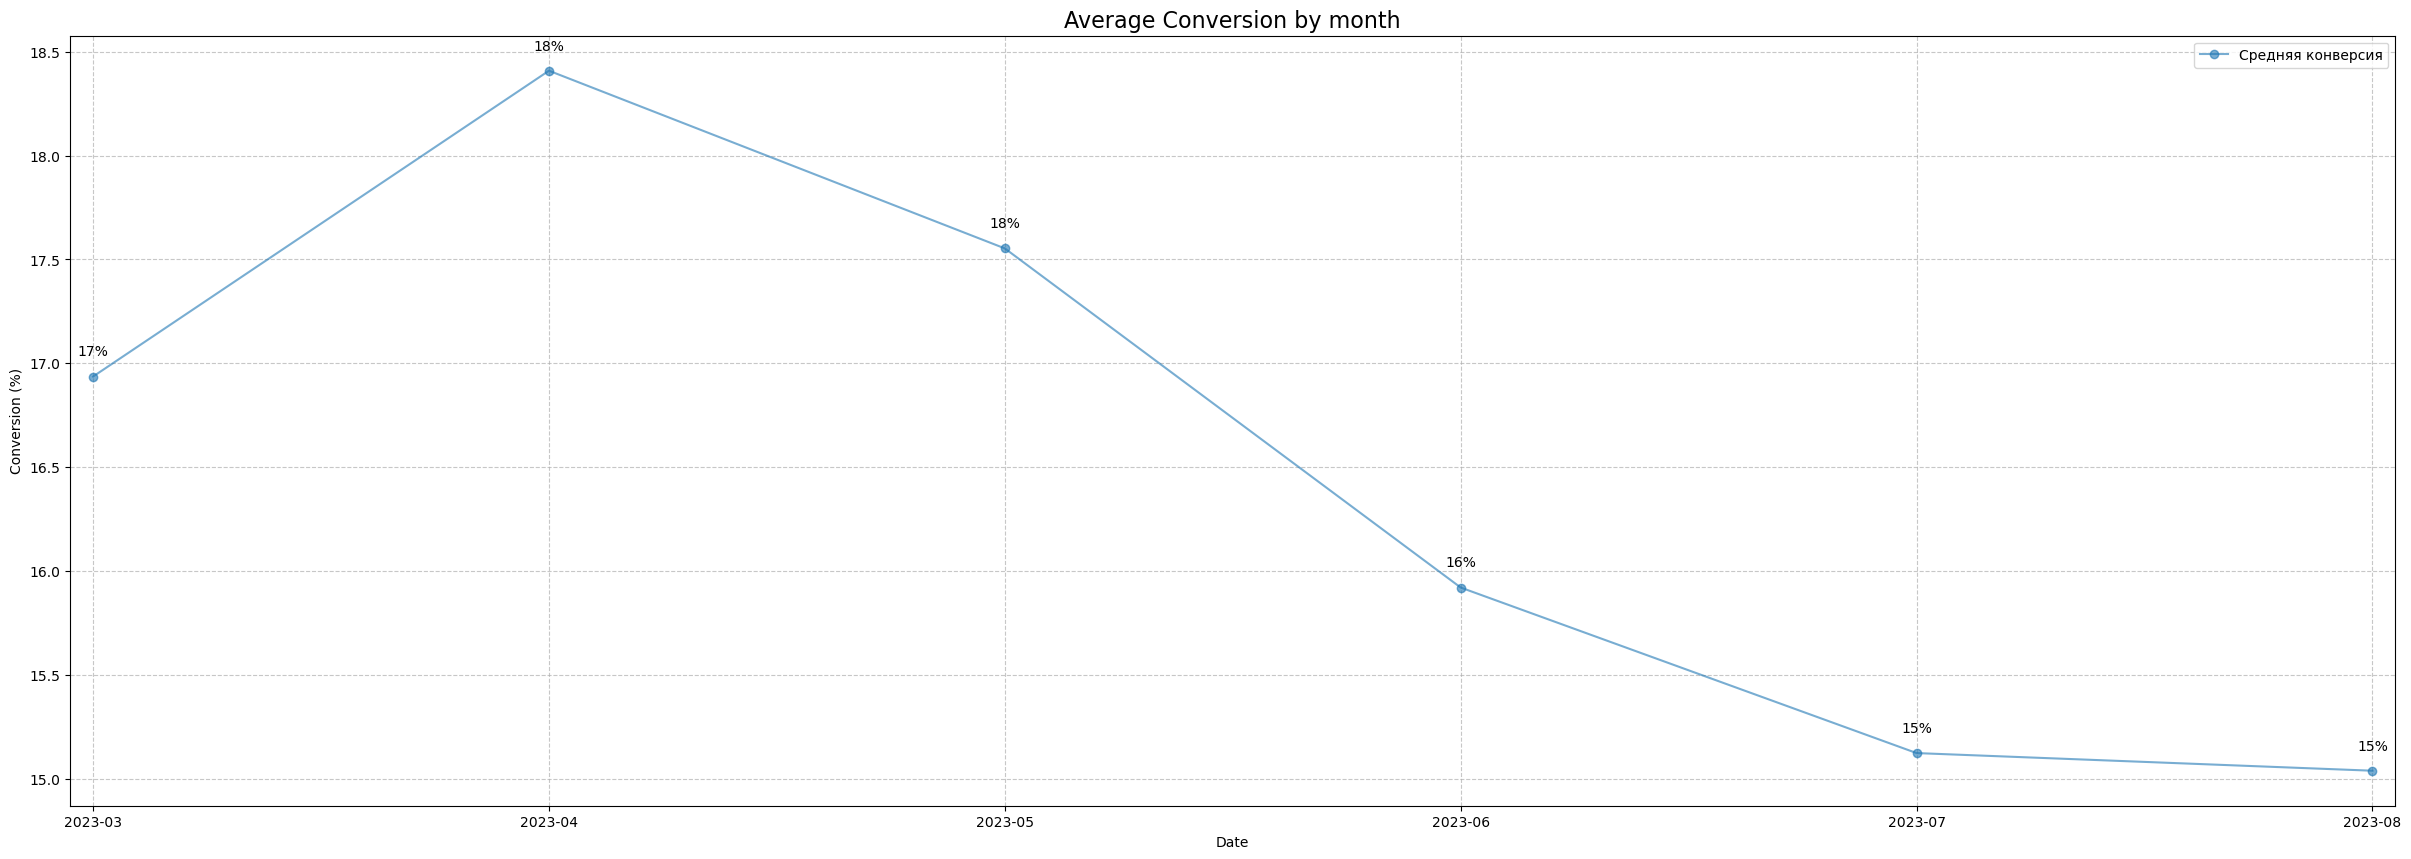

In [52]:
#Построение графика
plt.figure(figsize=(30,10))
plt.title('Average Conversion by month', fontsize=16)
plt.plot(conversion_monthly['date_group'], conversion_monthly['conversion'], marker='o', label="Средняя конверсия", alpha=0.6)
plt.xlabel("Date")
plt.ylabel("Conversion (%)")
plt.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.margins(x=0.01)

for i, txt in enumerate(conversion_monthly['conversion']):
    plt.text(conversion_monthly['date_group'][i], conversion_monthly['conversion'][i] + 0.1, f'{txt:.0f}%', ha='center', fontsize=10)

plt.savefig('./charts/Average_Conversion_by_month.png')
plt.show()

**Вывод:** Средняя конверсия с каждым месяцам уменьшается, но остается на довольно высоком уровне 15%. Вероятнее всего, спад связан с неэффективной рекламной кампанией в эти месяцы или техническим сбоем регистраций, так как в период с июля по август среднее количество визитов составляет 813 посещений в день.

<h3>Седьмой график - "Конверсия по каждой платформе"</h3>

In [55]:
#Подготовка данных для визуализации
conversion_android = conversion[conversion['platform'].str.contains('android')].reset_index()
conversion_ios = conversion[conversion['platform'].str.contains('ios')].reset_index()
conversion_web = conversion[conversion['platform'].str.contains('web')].reset_index()
avg_conversion_android = conversion_android['conversion'].mean()
avg_conversion_ios = conversion_ios['conversion'].mean()
avg_conversion_web = conversion_web['conversion'].mean()
print(f'Средняя конверсия android: {avg_conversion_android}\nСредняя конверсия ios: {avg_conversion_ios}\nСредняя конверсия web: {avg_conversion_web}')

Средняя конверсия android: 76.80412239480349
Средняя конверсия ios: 75.88052794248019
Средняя конверсия web: 5.823100884407492


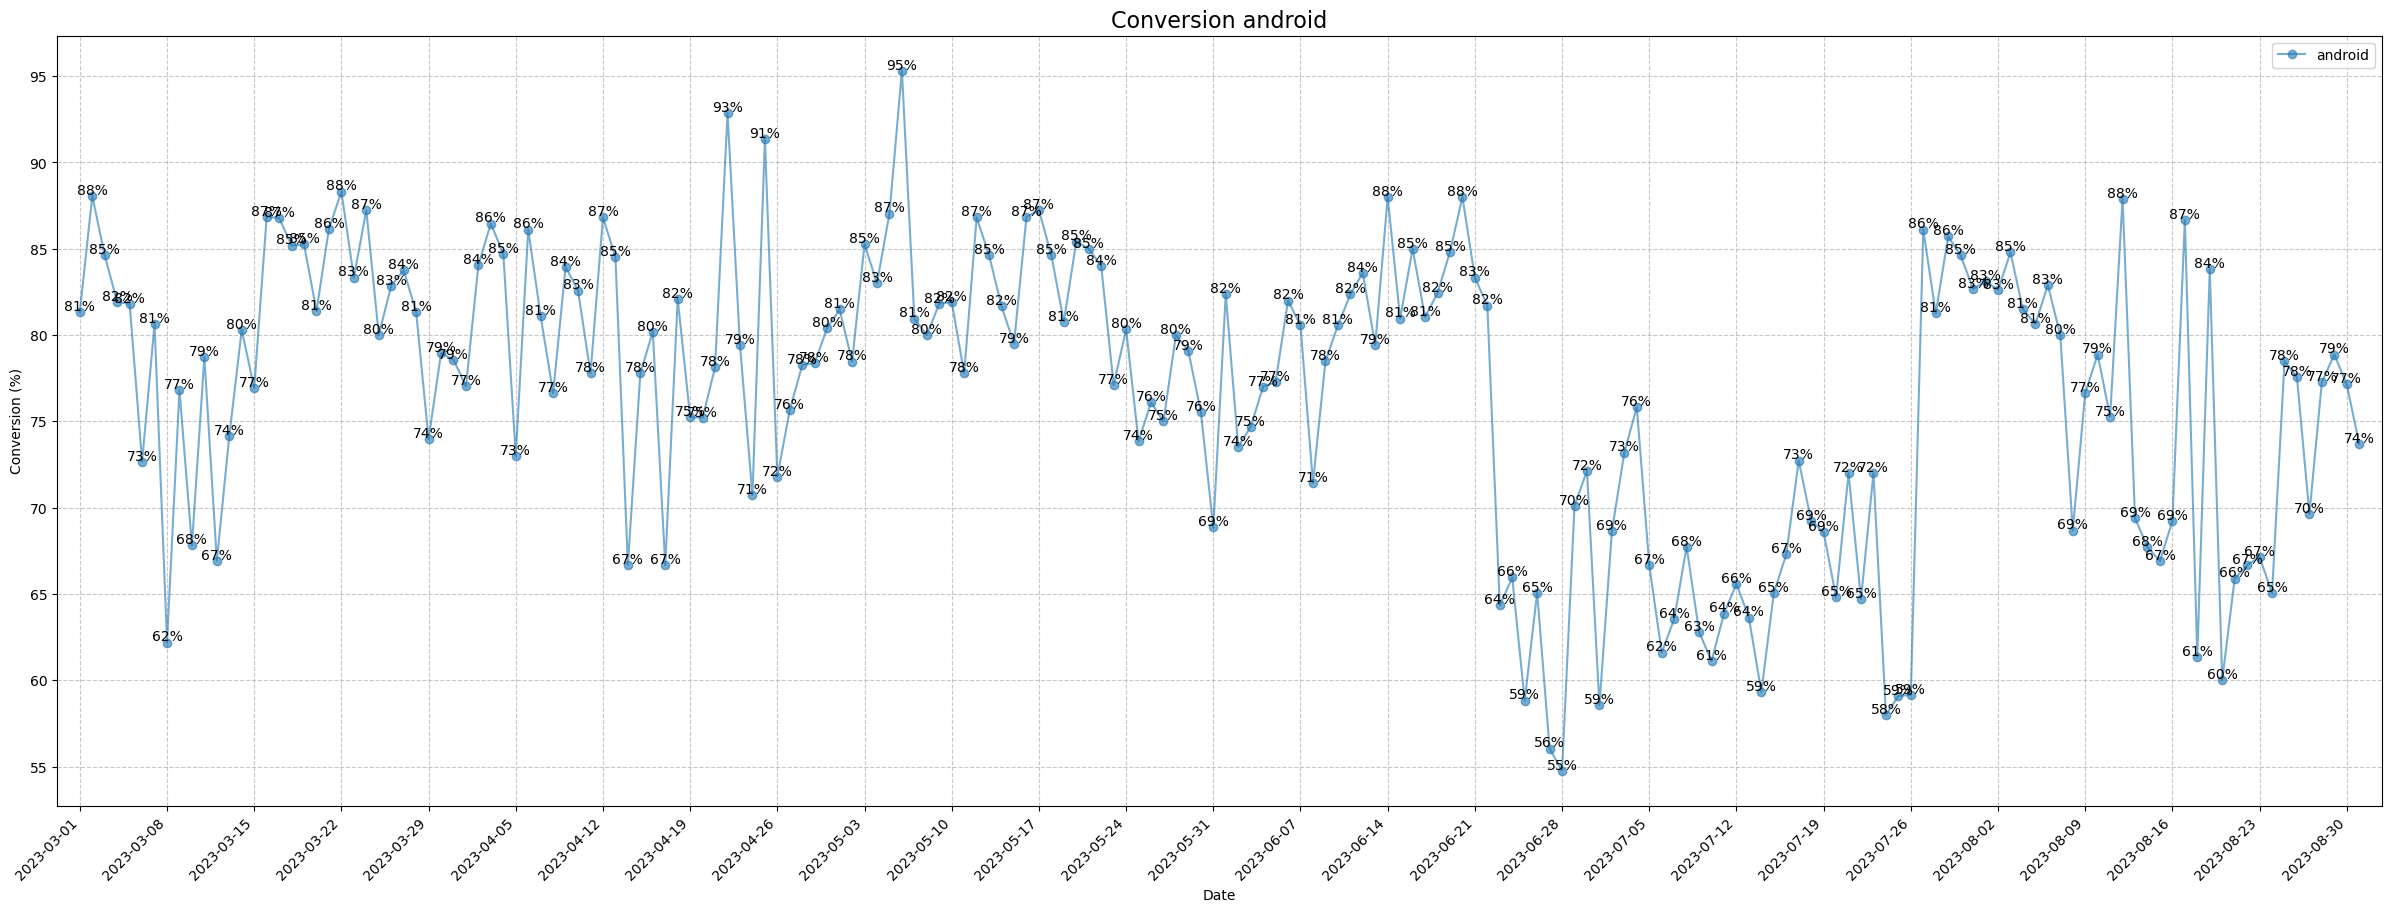

In [56]:
#Построение графика Android
plt.figure(figsize=(30,10))
plt.title('Conversion android', fontsize=16)
plt.plot(conversion_android['date_group'], conversion_android['conversion'], marker='o', label='android', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.xticks(conversion_android['date_group'][::7], rotation=45, ha="right")
plt.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.margins(x=0.01)

for i, txt in enumerate(conversion_android['conversion']):
    plt.text(conversion_android['date_group'][i], conversion_android['conversion'][i] + 0.1, f'{txt:.0f}%', ha='center', fontsize=10)

plt.savefig('./charts/Conversion_android.png')
plt.show()

**Выводы:** В целом по графику видно, что конверсия *Android* довольно высокая в пределах 60-90%, что означает, что пользователи, приходящие на платформу, в большинстве случаев регистрируются. Средняя конверсия *Android*: 77%

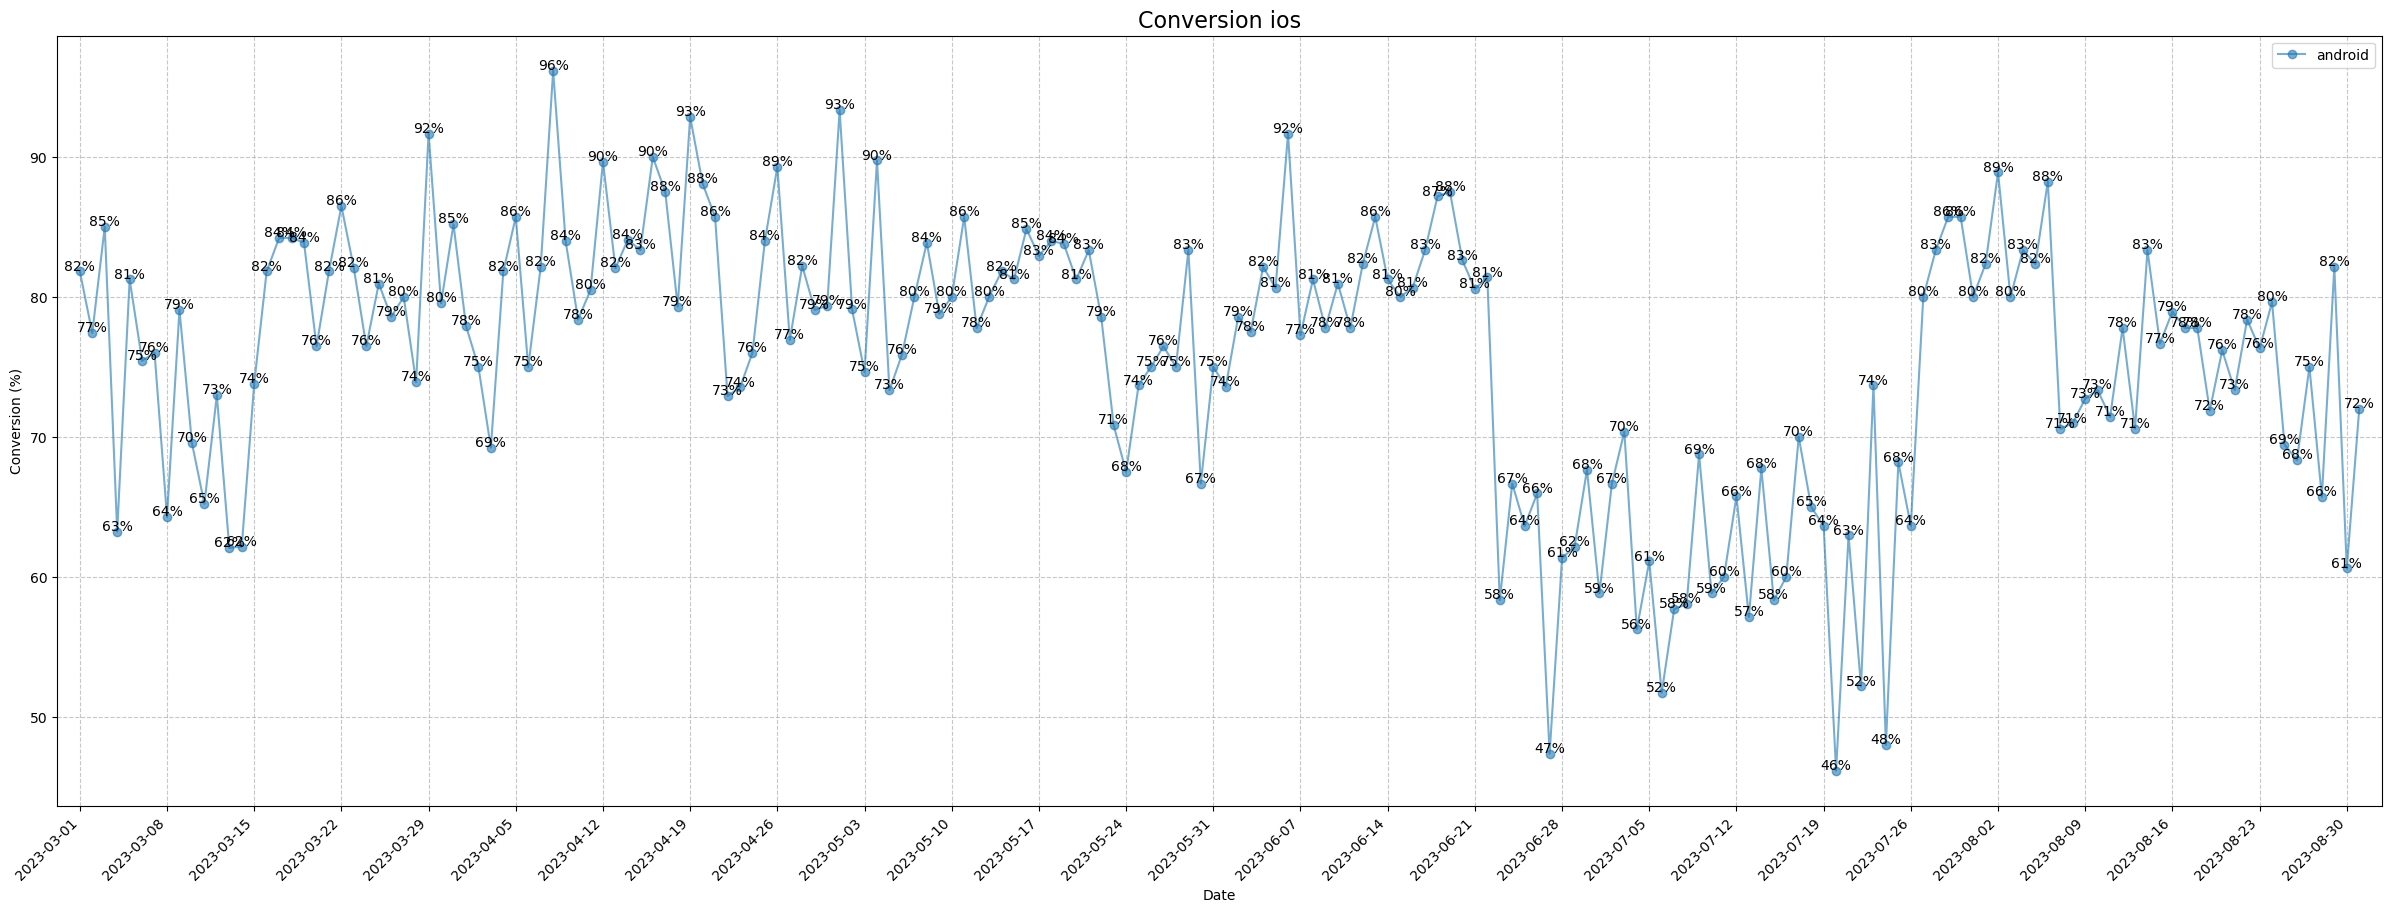

In [58]:
#Построение графика iOS
plt.figure(figsize=(30,10))
plt.title('Conversion ios', fontsize=16)
plt.plot(conversion_ios['date_group'], conversion_ios['conversion'], marker='o', label='android', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.xticks(conversion_ios['date_group'][::7], rotation=45, ha="right")
plt.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.margins(x=0.01)

for i, txt in enumerate(conversion_ios['conversion']):
    plt.text(conversion_ios['date_group'][i], conversion_ios['conversion'][i] + 0.1, f'{txt:.0f}%', ha='center', fontsize=10)

plt.savefig('./charts/Conversion_ios.png')
plt.show()

**Выводы:** Коверсия *iOS* также на высоком уровне: в большинстве дней она превышает 75%, а иногда достигает 90–96%. Средняя конверсия *iOS* составляет 76%.

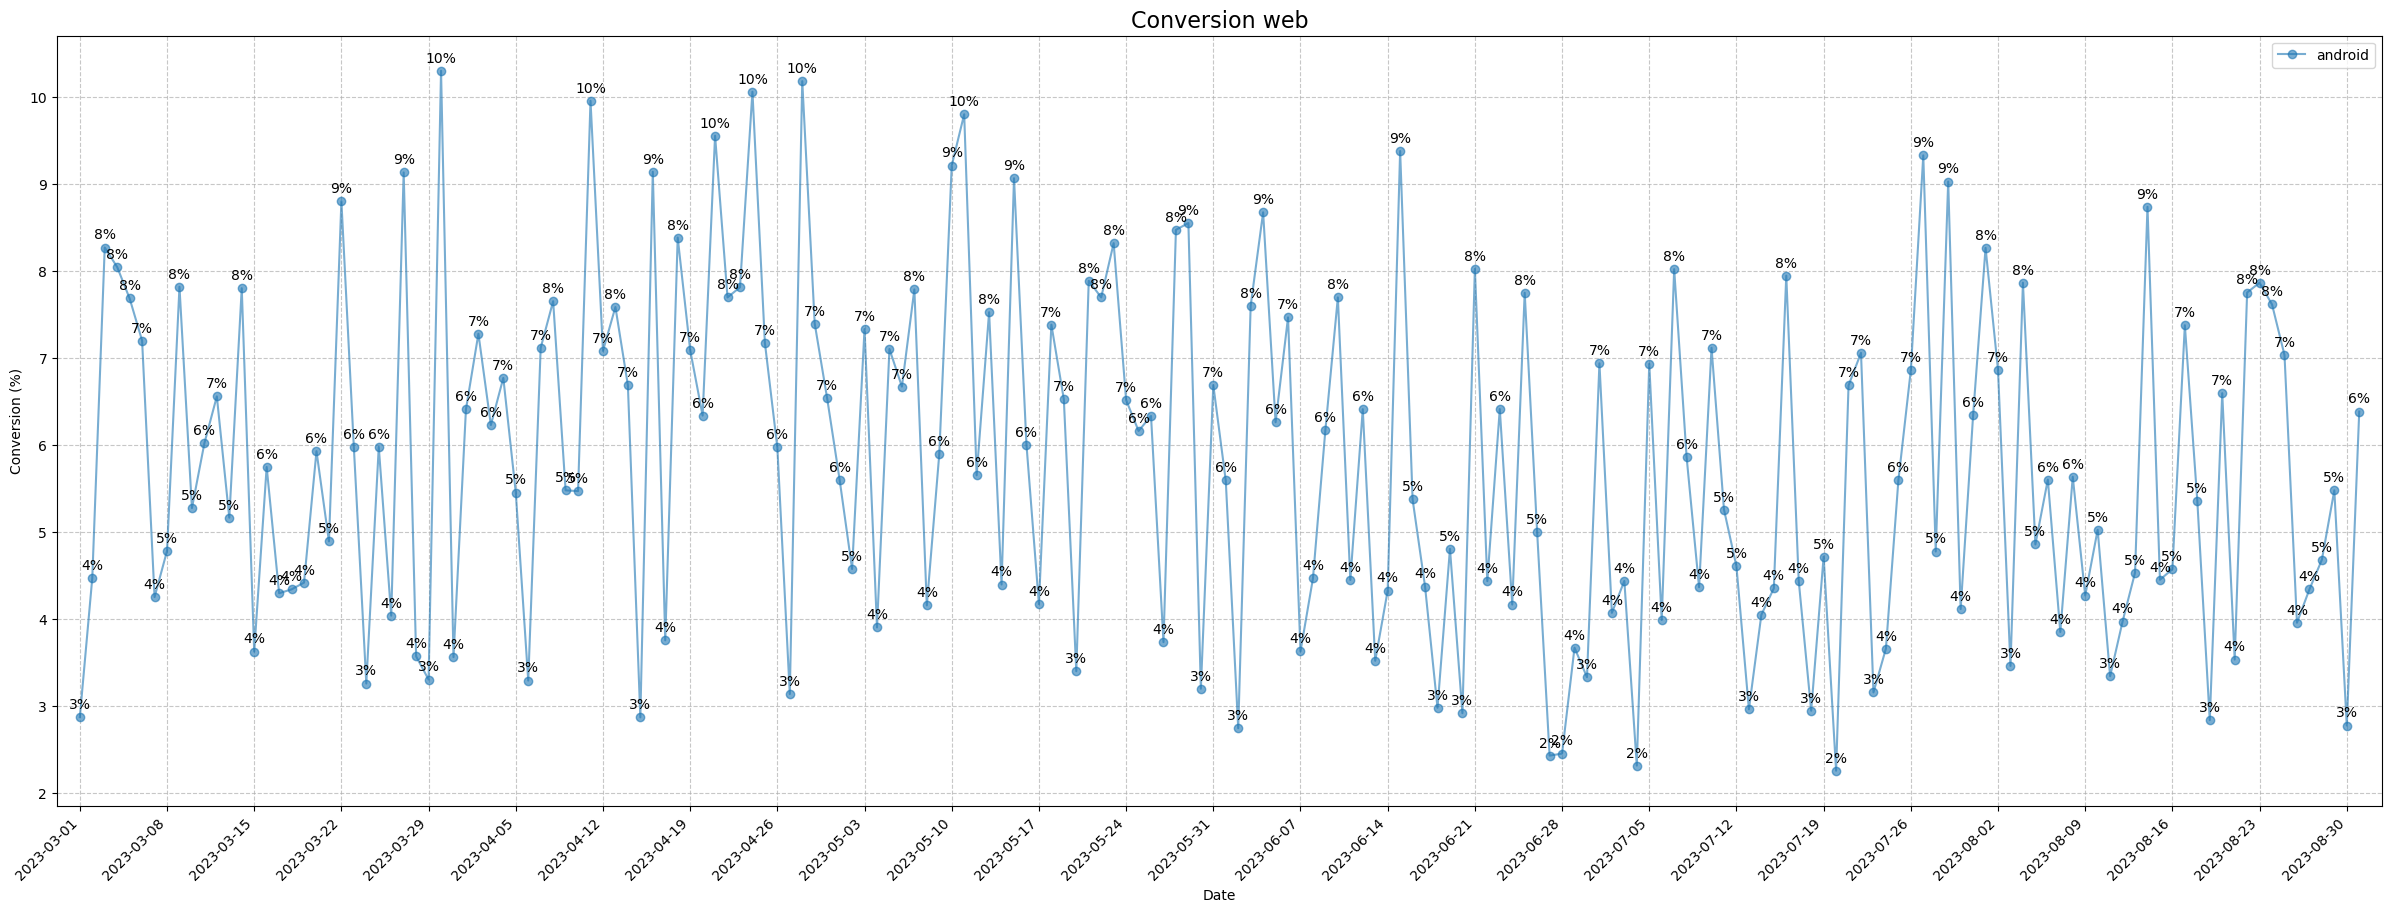

In [60]:
#Построение графика web
plt.figure(figsize=(30,10))
plt.title('Conversion web', fontsize=16)
plt.plot(conversion_web['date_group'], conversion_web['conversion'], marker='o', label='android', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.xticks(conversion_web['date_group'][::7], rotation=45, ha="right")
plt.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.margins(x=0.01)

for i, txt in enumerate(conversion_web['conversion']):
    plt.text(conversion_web['date_group'][i], conversion_web['conversion'][i] + 0.1, f'{txt:.0f}%', ha='center', fontsize=10)

plt.savefig('./charts/Conversion_web.png')
plt.show()

**Выводы:** Конверсия *web* по сравнинию с мобильными платформами на низком уровне, также наблюдаются резкие скачки и падениями. Значения варьируются от 3 до 9 %. Средняя конверсия *web:* 6%. На *web* посещаемость выше, но конверсия ниже. Мобильные платформы (*iOS, Android*) конвертируют пользователей в 8-10 раз лучше. Возможно, пользователи заходят с *web* для ознакомления, но не готовы регистрироваться.

Необходимо анализировать источники трафика: возможно, реклама приводит нерелевантную аудиторию.

<h3>Восьмой график - "Стоимости реклам"</h3>

Для подготовки графика возьмем готовый датафрейм с рекламными кампаниями (campaign_conversions)

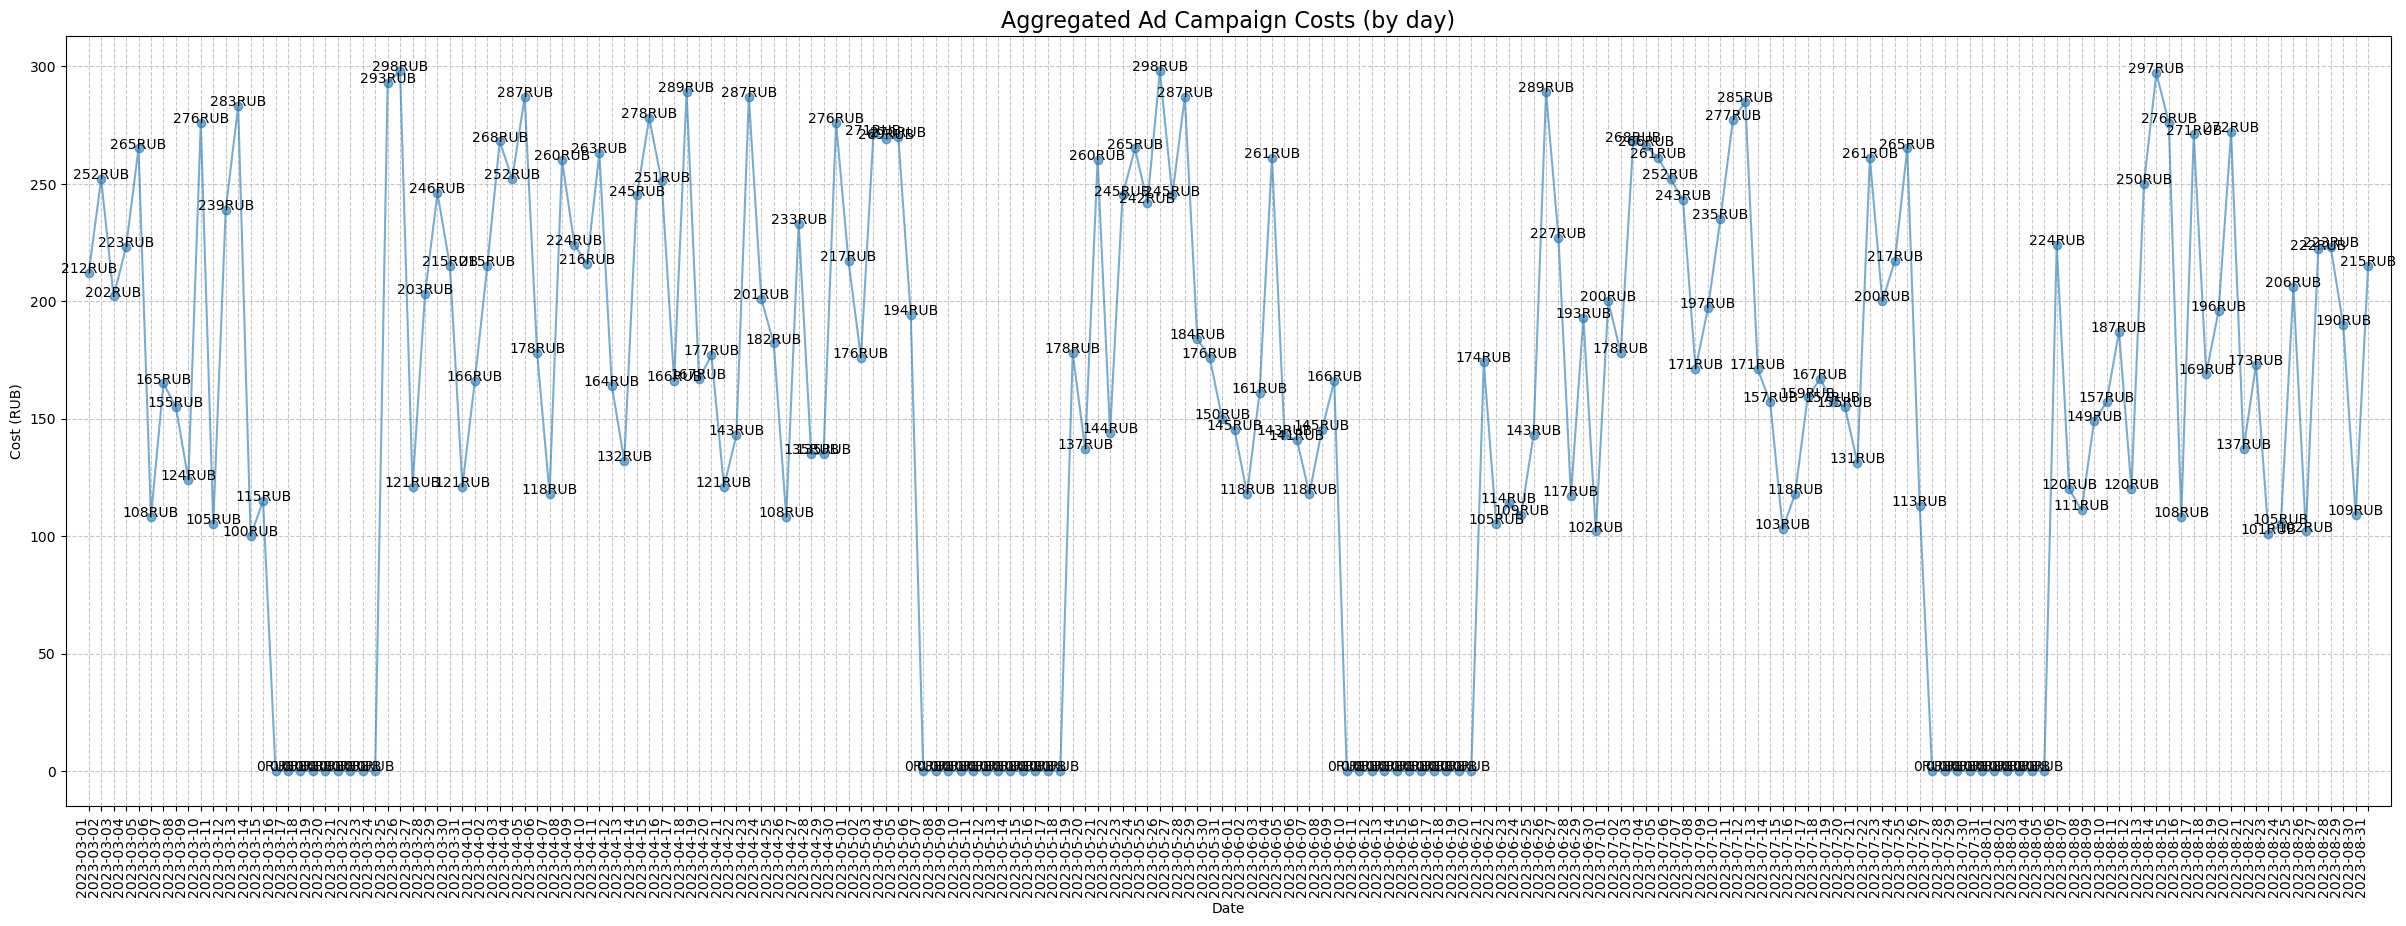

In [64]:
#Построение графика
plt.figure(figsize=(30,10))
plt.title('Aggregated Ad Campaign Costs (by day)', fontsize=16)
plt.plot(campaign_conversions['date_group'], campaign_conversions['cost'], marker='o', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Cost (RUB)')
plt.xticks(campaign_conversions['date_group'], rotation=90, ha="right")
plt.grid(linestyle='--', alpha=0.7)
plt.margins(x=0.01)

for i, txt in enumerate(campaign_conversions['cost']):
    plt.text(campaign_conversions['date_group'][i], campaign_conversions['cost'][i] + 0.1, f'{txt:.0f}RUB', ha='center', fontsize=10)

plt.savefig('./charts/Aggregated_Ad_Campaign_Costs.png')
plt.show()

**Выводы:** Расходы на рекламу значительно колеблются от 0 до почти 300 RUB в день. Видны четкие периоды "обнуления" расходов — это дни, когда реклама не запускалась. В периоды активности расходы стабильно держатся в диапазоне 100–290 RUB.
Необходимо провести оптимизацию бюджета, если затраты часто падают до 0, возможно, стоит перераспределить бюджет, чтобы обеспечить постоянный охват без пауз, проверить, какие кампании приносят лучший результат и перераспределить бюджет в их пользу.

<h3>Девятый график - "Визиты и регистрации с выделением рекламных кампаний"</h3>

In [67]:
#Подготовка данных для визуализации визитов и регистраций
campaign_conversions["visits_mean"] = campaign_conversions["visits"].mean()
campaign_conversions["reg_mean"] = campaign_conversions["registrations"].mean()
campaign_conversions.head()

,date_group,visits,registrations,cost,utm_campaign,visits_mean,reg_mean
0,2023-03-01,376,87,212.0,advanced_algorithms_series,753.820652,118.673913
1,2023-03-02,613,106,252.0,advanced_algorithms_series,753.820652,118.673913
2,2023-03-03,683,107,202.0,advanced_algorithms_series,753.820652,118.673913
3,2023-03-04,647,159,223.0,advanced_algorithms_series,753.820652,118.673913
4,2023-03-05,707,115,265.0,advanced_algorithms_series,753.820652,118.673913


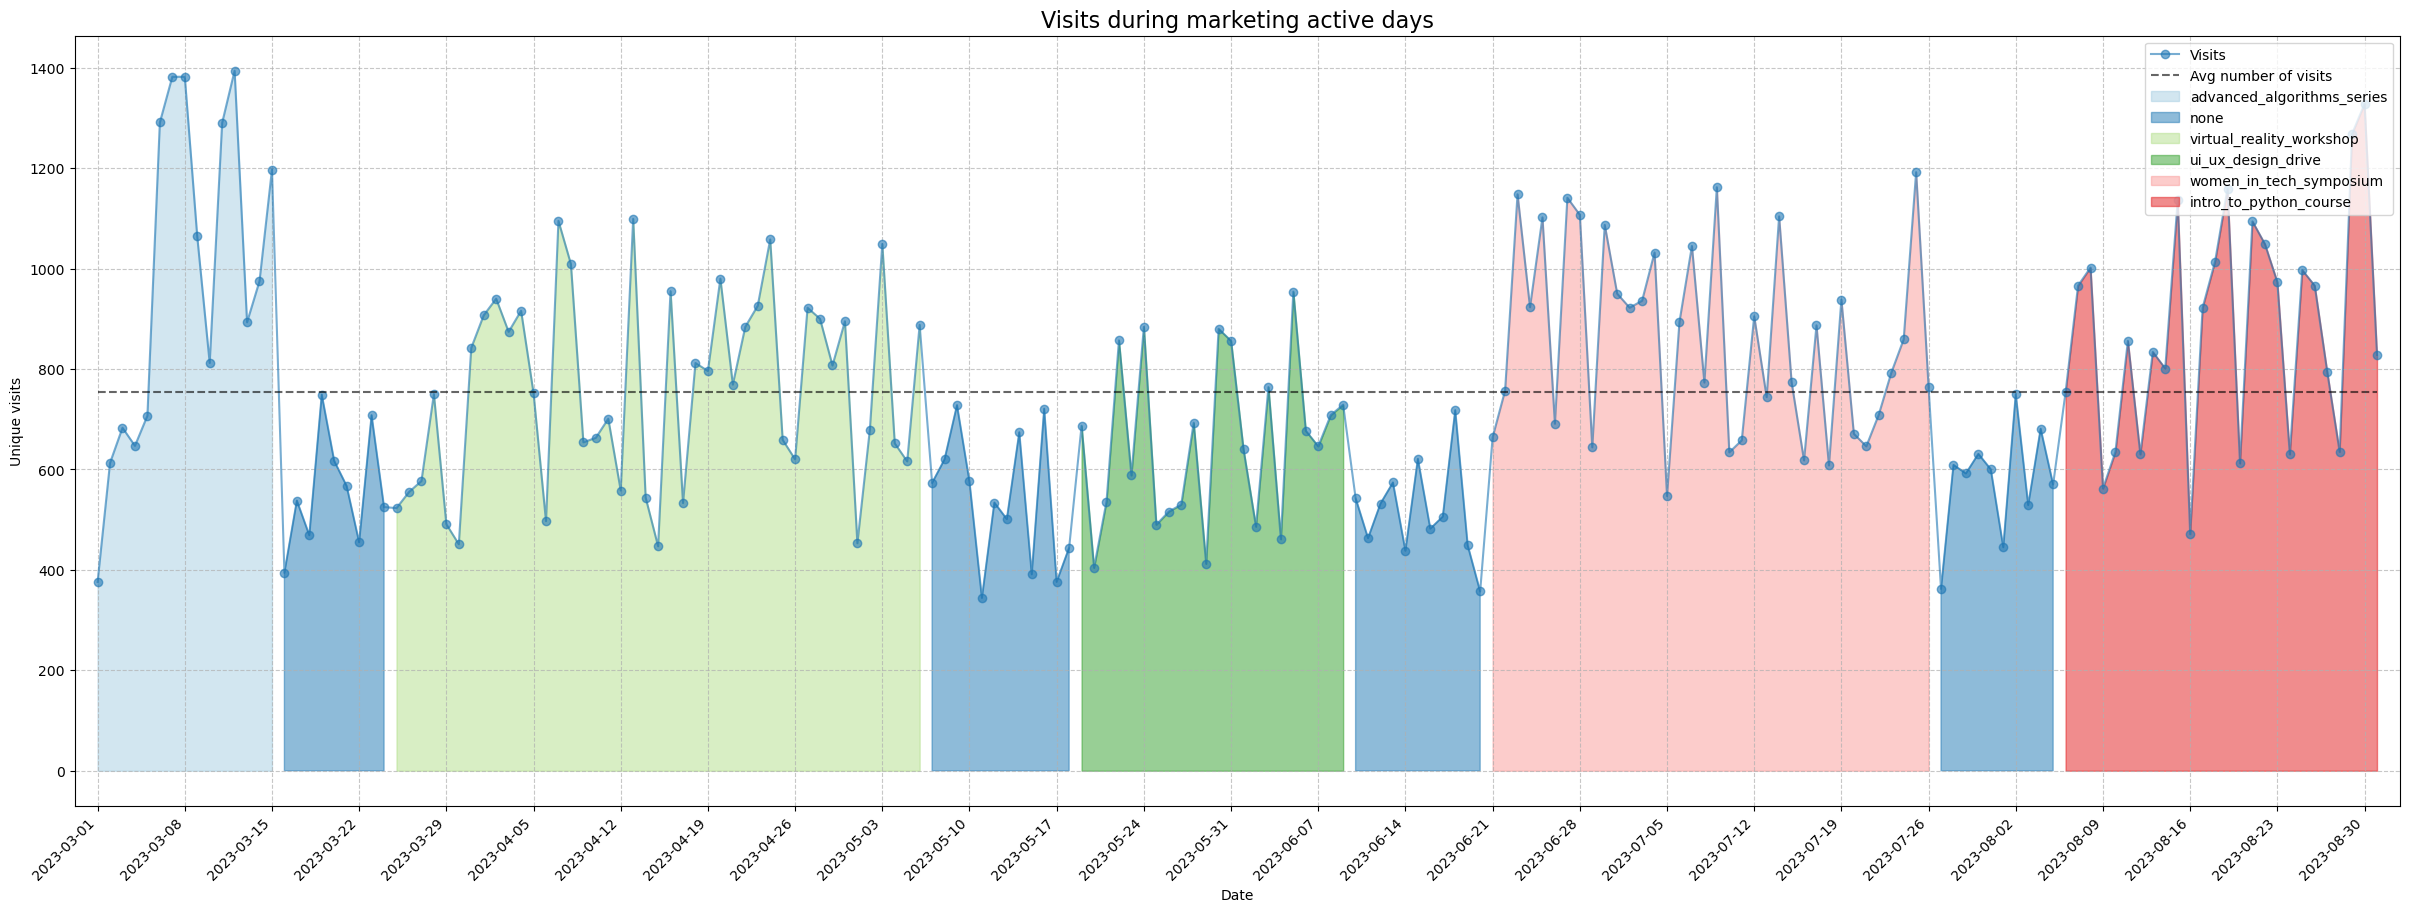

In [68]:
#Построение графика Визиты за весь период с цветовым выделением рекламной кампании
plt.figure(figsize=(30,10))
plt.title('Visits during marketing active days', fontsize=16)
plt.plot(campaign_conversions['date_group'], campaign_conversions['visits'], label="Visits", marker='o', alpha=0.6)
plt.plot(campaign_conversions['date_group'], campaign_conversions['visits_mean'], label="Avg number of visits", linestyle='--', color='black', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Unique visits')
plt.xticks(campaign_conversions['date_group'][::7], rotation=45, ha="right")
plt.grid(linestyle='--', alpha=0.7)
plt.margins(x=0.01)

campaigns = campaign_conversions['utm_campaign'].unique()
colors = plt.cm.Paired(range(len(campaigns)))

for campaign, color in zip(campaigns, colors):
   mask = campaign_conversions["utm_campaign"] == campaign
   plt.fill_between(campaign_conversions["date_group"], campaign_conversions["visits"], where=mask, color=color, alpha=0.5, label=campaign)


plt.legend(loc='upper right')

plt.savefig('./charts/Visits_during_marketing_active_days.png')
plt.show()

**Выводы:** Видно, что во время активных кампаний количество визитов заметно варьируется. Некоторые кампании, такие как *advanced_algorithms_series*, *virtual_reality_workshop* и *intro_to_python_course*, показали относительно высокие пики посещаемости. В периоды, когда кампания отсутствует (none), наблюдаются снижения посещаемости. Среднее значение количество визитов составляет 753.

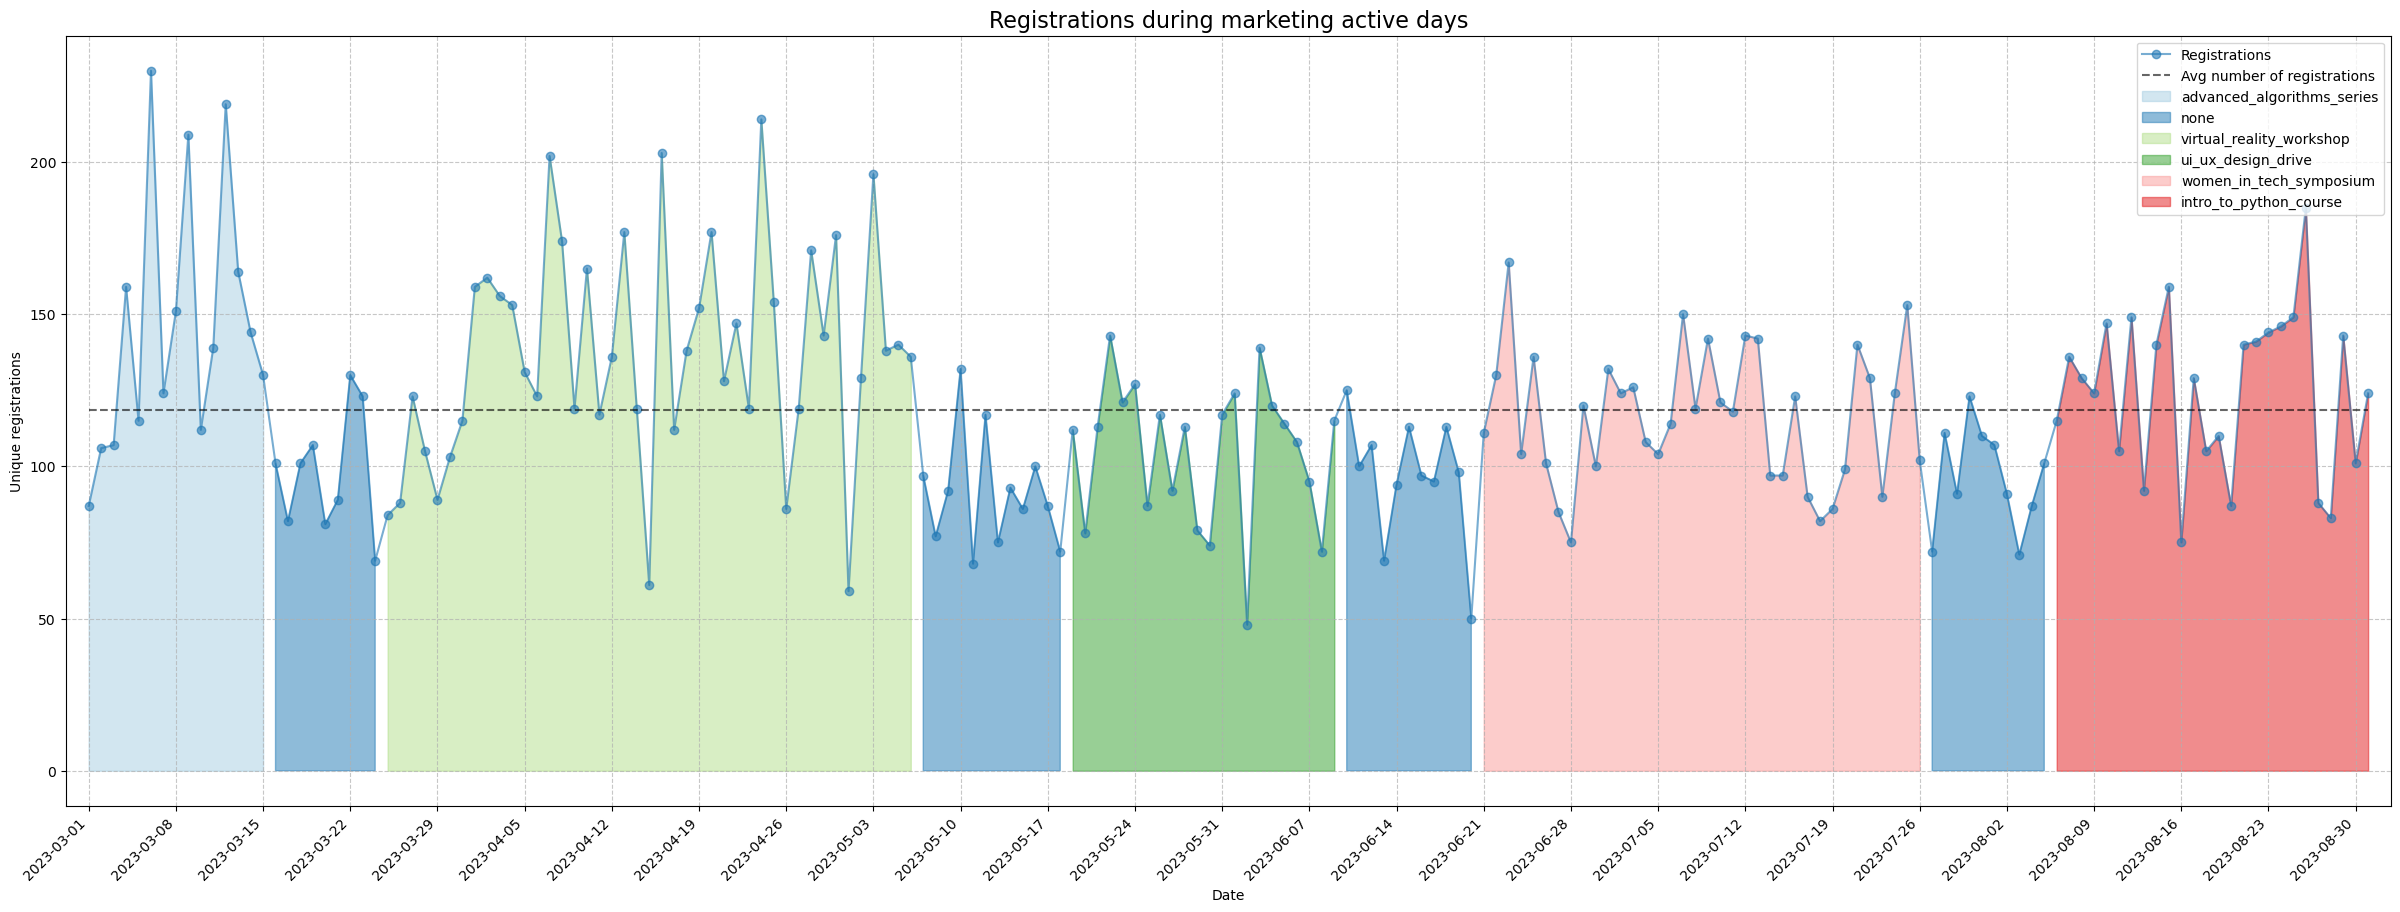

In [70]:
#Построение графика Регистрации за весь период с цветовым выделением рекламной кампании
plt.figure(figsize=(30,10))
plt.title('Registrations during marketing active days', fontsize=16)
plt.plot(campaign_conversions['date_group'], campaign_conversions['registrations'], label="Registrations", marker='o', alpha=0.6)
plt.plot(campaign_conversions['date_group'], campaign_conversions['reg_mean'], label="Avg number of registrations", linestyle='--', color='black', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Unique registrations')
plt.xticks(campaign_conversions['date_group'][::7], rotation=45, ha="right")
plt.grid(linestyle='--', alpha=0.7)
plt.margins(x=0.01)

campaigns = campaign_conversions['utm_campaign'].unique()
colors = plt.cm.Paired(range(len(campaigns)))

for campaign, color in zip(campaigns, colors):
    mask = campaign_conversions["utm_campaign"] == campaign
    plt.fill_between(campaign_conversions["date_group"], campaign_conversions["registrations"], where=mask, color=color, alpha=0.5, label=campaign)

plt.legend(loc='upper right')

plt.savefig('./charts/Registrations_during_marketing_active_days.png')
plt.show()

**Выводы:** Некоторые кампании (например,*advanced_algorithms_series*, *virtual_reality_workshop* и *intro_to_python_course*) вызывают не только рост визитов, но и рост регистраций. В целом, регистрации следуют за трендом визитов.